In [28]:
import numpy as np
import cv2 as cv
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time
import torch
from pathlib import Path

from lac.perception.segmentation import Segmentation
from lac.perception.depth import stereo_depth_from_segmentation, project_pixel_to_rover
from lac.control.controller import rock_avoidance_steering
from lac.utils.visualization import overlay_mask, overlay_stereo_rock_depths
from lac.utils.plotting import plot_points_rover_frame
from lac.util import load_data
import lac.params as params

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Hazard detection

Use combination of instance segmentation and depth estimation to identify hazards (rocks)

- Turn left (+Y) is positive, turn right (-Y) is negative


## Segmentation

Empirical observation: masks of area >50000 are typically outliers (full ground).


In [ ]:
segmentation = Segmentation()

In [ ]:
# data_path = os.path.expanduser("~/LunarAutonomyChallenge/output/hazard_2")
# data_path = os.path.expanduser("~/LunarAutonomyChallenge/output/localization_agent_ekf_teleop")
data_path = os.path.expanduser("~/LunarAutonomyChallenge/output/nav_agent_preset_2_seed_4")

i = 1000
FL_gray = cv.imread(os.path.join(data_path, "FrontLeft", f"{i}.png"), cv.IMREAD_GRAYSCALE)
FL_rgb_PIL = Image.fromarray(FL_gray).convert("RGB")

results, full_mask = segmentation.segment_rocks(FL_rgb_PIL)
overlay = overlay_mask(FL_gray, full_mask)

plt.imshow(overlay)
plt.show()

In [40]:
data_path = Path("../../output/NavAgent/default_run")
initial_pose, lander_pose, poses, imu_data, cam_config = load_data(data_path)

Predicting 1 masks
Predicted 1 masks
Predicting 1 masks
Predicted 1 masks


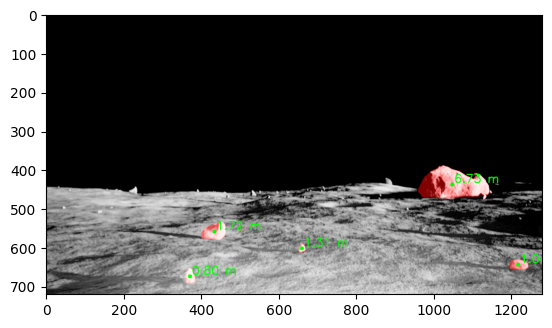

In [41]:
i = 1950

left_image = Image.open(data_path / "FrontLeft" / f"{i}.png")
right_image = Image.open(data_path / "FrontRight" / f"{i}.png")

left_seg_masks, left_seg_full_mask = segmentation.segment_rocks(left_image.convert("RGB"))
right_seg_masks, right_seg_full_mask = segmentation.segment_rocks(right_image.convert("RGB"))

results = stereo_depth_from_segmentation(
    left_seg_masks, right_seg_masks, params.STEREO_BASELINE, params.FL_X
)
left_overlay = overlay_mask(np.array(left_image), left_seg_full_mask)
left_overlay = overlay_stereo_rock_depths(left_overlay, results)
plt.imshow(left_overlay)

In [42]:
[mask.sum() for mask in left_seg_masks]

[11298.0, 2279.0, 1167.0, 334.0, 841.0]

In [43]:
[rock["left_mask"].sum() for rock in results]

[11298.0, 1167.0, 334.0, 2279.0, 841.0]

In [ ]:
rock_points_rover_frame = []
for rock in results:
    rock_points_rover_frame.append(
        project_pixel_to_rover(rock["left_centroid"], rock["depth"], "FrontLeft", cam_config)
    )
rock_points_rover_frame = np.array(rock_points_rover_frame)
plot_points_rover_frame(rock_points_rover_frame, color="red")

In [33]:
rock_avoidance_steering(results, cam_config)

Max mask area: 919.0


0.0

## Depth


In [ ]:
import os
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt

from lac.perception.depth import DepthAnything

In [ ]:
depth_model = DepthAnything()

In [ ]:
data_path = os.path.expanduser("~/LunarAutonomyChallenge/output/hazard_2")
# data_path = os.path.expanduser("~/LunarAutonomyChallenge/output/data_collection_1")

i = 1051
FL_gray = cv.imread(os.path.join(data_path, "front_left", f"{i}.png"), cv.IMREAD_GRAYSCALE)
plt.imshow(FL_gray, cmap="gray")
plt.show()

In [ ]:
import torch
from transformers import pipeline

checkpoint = "depth-anything/Depth-Anything-V2-base-hf"
pipe = pipeline("depth-estimation", model=checkpoint, device="cuda")

# # Force model outputs to use float32
# pipe.model.to(torch.float32)
pass

In [ ]:
image = Image.open(os.path.join(data_path, "front_left", f"{i}.png"))

In [ ]:
torch.set_default_dtype(torch.float32)

In [ ]:
print(torch.get_default_dtype())

In [ ]:
pipe(image)

In [ ]:
import os
from PIL import Image
from transformers import pipeline
import torch
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = "depth-anything/Depth-Anything-V2-base-hf"
pipe = pipeline("depth-estimation", model=checkpoint, device=device)

In [ ]:
i = 100

image_path = os.path.expanduser(
    "~/LunarAutonomyChallenge/output/data_collection_1/front_left/{}.png".format(i)
)
image_depth_in = Image.open(image_path)

predictions = pipe(image_depth_in)

# Plot image and predicted depth side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={"wspace": 0, "hspace": 0})
axes[0].imshow(image_depth_in, cmap="gray")
axes[1].imshow(predictions["depth"], cmap="gray")
for ax in axes:
    ax.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
image = Image.open(os.path.join(data_path, "front_left", f"{i}.png"))
predictions = pipe(image)

# Plot image and predicted depth side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={"wspace": 0, "hspace": 0})
axes[0].imshow(image, cmap="gray")
axes[1].imshow(predictions["depth"], cmap="gray")
for ax in axes:
    ax.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()